energy:(Hartree) 0.19456813255315636


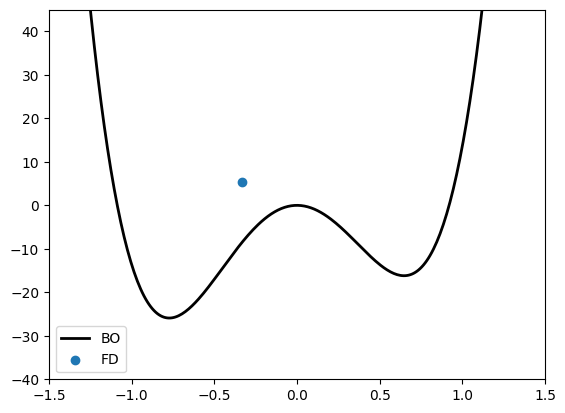

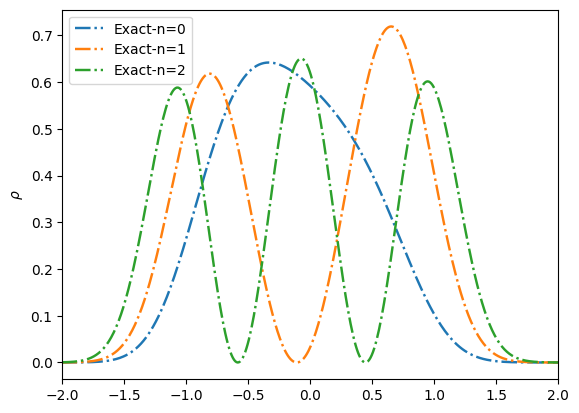

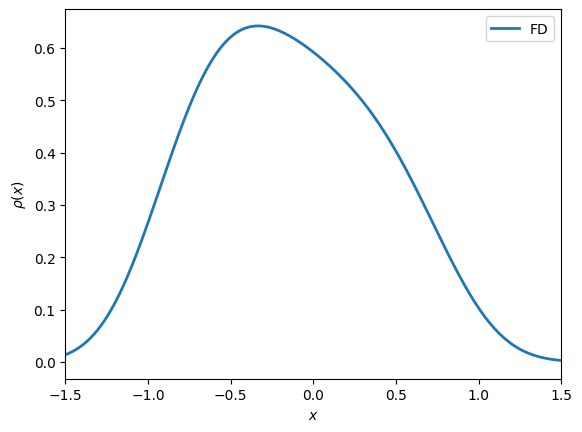

Excitation Energies:(Hartree)
[ 0.19456813  1.73513997  4.54932271  7.82492991 11.54729191 15.62874664
 20.0204506  24.68666156 29.60034415 34.74017723 40.0888437 ]


In [1]:
# import jax.numpy as np
import numpy as np


#mesh of the finite difference 
xmin = -10; xmax = 10; Nmesh = 2000
xmesh = np.linspace(xmin, xmax, Nmesh)
h = xmesh[1] - xmesh[0]

def Vpot(x):
    return 3*x**4 + x**3/2 - 3*x**2

def Vpot_harmonic(x):
    return x**2/2
    
def buildH(Vpot):
    Vx = Vpot(xmesh)
    Vx = np.diag(Vx,0,)
    H_kinetic = (-2 * np.diag(np.ones(Nmesh,), 0) + np.diag(np.ones(Nmesh - 1, ), 1) + np.diag(np.ones(Nmesh - 1, ), -1))/(2 * h**2)

    H = Vx - H_kinetic
    
    return H 

if __name__=='__main__':

    hartree2ev = 27.2107
    H = buildH(Vpot)
    w, v = np.linalg.eigh(H)
    idx_sorted = np.argsort(w)
    w,v = w[idx_sorted], v[:, idx_sorted]
    gs_wf = v[:,0]
    normalize_factor = (gs_wf**2).sum() * h
    # rescale to probability amplitude
    gs = gs_wf**2 / normalize_factor
    
    nlowest = 1
    print ('energy:(Hartree)', w[0])

    import matplotlib.pyplot as plt

    xmes_argmax = gs.argmax()
    plt.plot(xmesh, Vpot(xmesh)*hartree2ev, 'k-', lw=2, label="BO")
    plt.scatter(xmesh[xmes_argmax], w[0:nlowest]*hartree2ev,label="FD")
    plt.xlim([-1.5,1.5])
    plt.ylim([-40,45])
    plt.legend()
    plt.show()

    state_indices = np.array([0,1,2])
    for i in state_indices:
        exact_wf_on_mesh = v[:, i]
        normalize_factor = (exact_wf_on_mesh**2).sum() * h
        exact_prob_density = exact_wf_on_mesh**2 / normalize_factor
        plt.plot(xmesh, exact_prob_density, "-.", label=f"Exact-n={i}", lw=1.75)
    plt.xlim([-2.0, 2.0])
    plt.legend()
    plt.ylabel(r"$\rho$")
    plt.show()

    plt.plot(xmesh, gs, label='FD', lw=2)
    plt.xlim([-1.5,1.5])
    plt.xlabel('$x$')
    plt.ylabel(r'$\rho(x)$')
    plt.legend()
    plt.show()

    print("Excitation Energies:(Hartree)")
    num_of_orbs = 10
    print(f"{w[:num_of_orbs+1:]}")

In [2]:
H_harmonic = buildH(Vpot_harmonic)
w_harmonic, v_harmonic = np.linalg.eigh(H_harmonic)


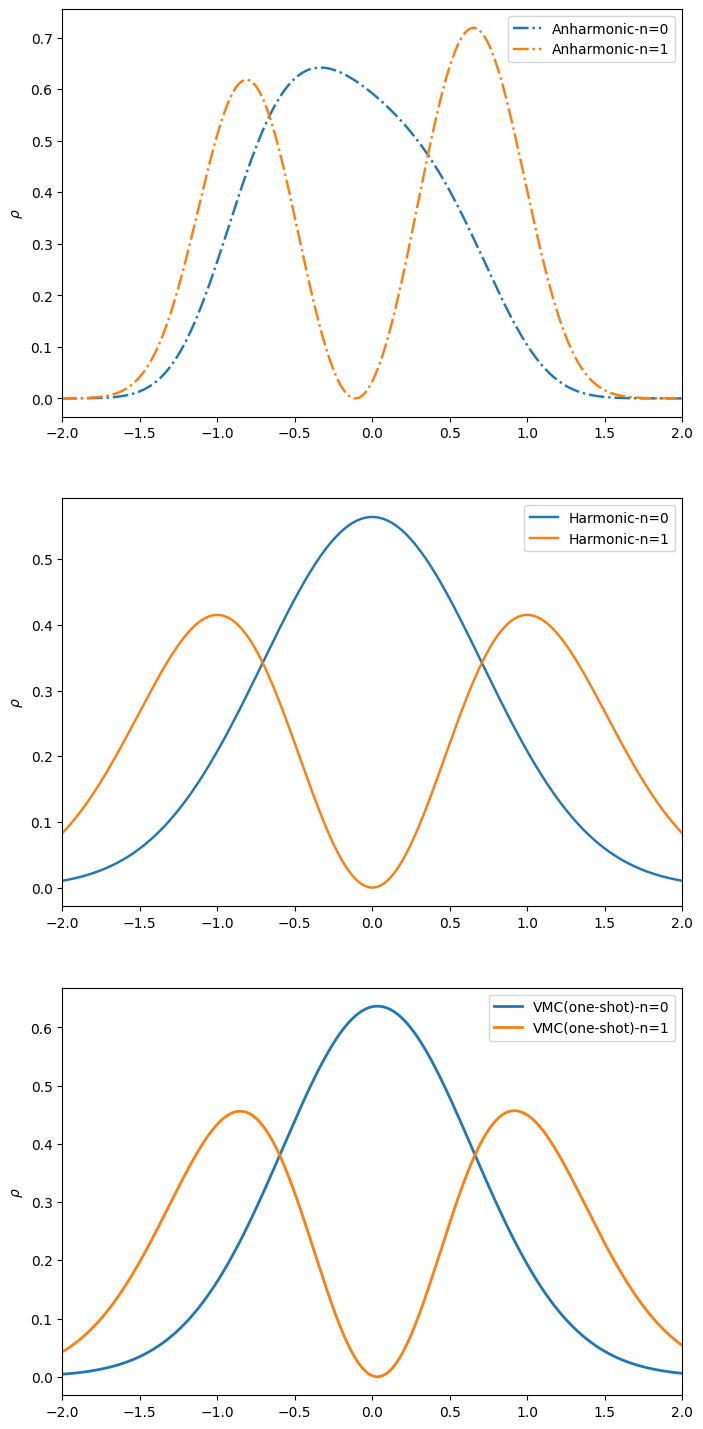

Inspecting at x=1.015507753876939
(harmonic) rho_0/rho_1 = 0.48483675445238567
(anharmonic) rho_0/rho_1 = 0.2517113281527554
(anharmonic, flowed) rho_0/rho_1 = 0.41571567223170564



In [12]:
inspect_index = int(11*Nmesh/20+1)
inspect_x = xmesh[inspect_index]
inspect_rho_anharmonic = []
inspect_rho_harmonic = []

state_indices = np.array([0,1])
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(8,18))
for i in state_indices:
    exact_wf_on_mesh = v[:, i]
    normalize_factor = (exact_wf_on_mesh**2).sum() * h
    exact_wf_on_mesh = exact_wf_on_mesh**2 / normalize_factor
    exact_wf_on_mesh_harmonic = v_harmonic[:, i]
    normalize_factor_harmonic = (exact_wf_on_mesh_harmonic**2).sum() * h
    exact_wf_on_mesh_harmonic = exact_wf_on_mesh_harmonic**2 / normalize_factor_harmonic
    inspect_rho_anharmonic.append(exact_wf_on_mesh[inspect_index])
    inspect_rho_harmonic.append(exact_wf_on_mesh_harmonic[inspect_index])
    ax1.plot(xmesh, exact_wf_on_mesh, "-.", label=f"Anharmonic-n={i}", lw=1.75)
    ax2.plot(xmesh, exact_wf_on_mesh_harmonic, "-", label=f"Harmonic-n={i}", lw=1.75)
ax1.set_xlim([-2.0, 2.0])
ax2.set_xlim([-2.0, 2.0])
ax1.legend()
ax2.legend()
ax1.set_ylabel(r"$\rho$")
ax2.set_ylabel(r"$\rho$")

inspect_rho_anharmonic = np.array(inspect_rho_anharmonic)
inspect_rho_harmonic = np.array(inspect_rho_harmonic)

import sys
sys.path.append("../")
from VMC.utils import WFAnsatz
# from VMC.utils import MLPSingleFlow
import jax
import jax.numpy as jnp
from flax import linen as flax_nn

class MLPSingleFlow(flax_nn.Module):
    """A simple MLP flow"""

    out_dims: int
    mlp_width: int
    mlp_depth: int

    def single_state(self, x):
        """Single state flow"""
        x = x.reshape((1,))
        x = flax_nn.Dense(self.mlp_depth)(x)
        x = flax_nn.sigmoid(x)
        x = flax_nn.Dense(1)(x)
        return x.reshape(-1)

    @flax_nn.compact
    def __call__(self, x):
        for i in range(self.mlp_depth):
            _init_x = x
            x = self.single_state(x)
            x = _init_x + x
        return x



key = jax.random.PRNGKey(42)
flow = MLPSingleFlow(1,2,2)
x_dummy = jnp.zeros((1,))
params = flow.init(key,x_dummy)
wf_ansatz_obj = WFAnsatz(flow=flow)
wf_ansatz_single= wf_ansatz_obj.wf_ansatz
wf_ansatz = jax.vmap(wf_ansatz_single,in_axes=(None,0,0))
xmesh_fock = np.tile(xmesh, state_indices.shape[0]).reshape(
        state_indices.shape[0], Nmesh
    )
wfs_ansatz_on_mesh = jax.vmap(
        wf_ansatz,
        in_axes=(None, 1, None),
        out_axes=0,
    )(params, xmesh_fock, state_indices)
inspect_rho_anharmonic_wf_ansatz = []
for i in state_indices:
    wf_ansatz_on_mesh = wfs_ansatz_on_mesh[:, i]
    normalize_factor_wf_ansatz = (wf_ansatz_on_mesh**2).sum() * h
    wf_ansatz_on_mesh = (wf_ansatz_on_mesh**2) / normalize_factor_wf_ansatz
    ax3.plot(xmesh, wf_ansatz_on_mesh, label=f"VMC(one-shot)-n={i}", lw=2)
    inspect_rho_anharmonic_wf_ansatz.append(wf_ansatz_on_mesh[inspect_index])
ax3.set_xlim([-2.0, 2.0])
ax3.legend()
ax3.set_ylabel(r"$\rho$")
plt.show()

inspect_rho_anharmonic_wf_ansatz = np.array(inspect_rho_anharmonic_wf_ansatz)

print(
    f"Inspecting at x={inspect_x}\n"
    f"(harmonic) rho_0/rho_1 = {inspect_rho_harmonic[0]/inspect_rho_harmonic[1]}\n"
    f"(anharmonic) rho_0/rho_1 = {inspect_rho_anharmonic[0]/inspect_rho_anharmonic[1]}\n"
    f"(anharmonic, flowed) rho_0/rho_1 = {inspect_rho_anharmonic_wf_ansatz[0]/inspect_rho_anharmonic_wf_ansatz[1]}\n"
      )

